In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload
import os
from collections import Counter

import TunaSims
import func_ob
import tools
import datasetBuilder

Results for Different Ways of Distributing Interspectral Intensity Difference

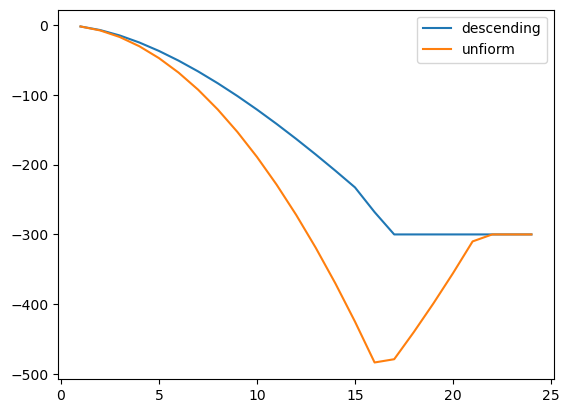

In [2]:
xs=list()
scores_1=list()
scores_2=list()

total_difference = 0.9
len_difference = 10
max_len = 25

func1 = partial(TunaSims.tuna_dif_distance,e=1,f=-1,h=500, i=-3,j=2,k=-800)
func2 = partial(TunaSims.tuna_dif_distance,e=1,f=-1,h=500,i=-3,j=2,k=-800)

normalize = False

for i in range(1,max_len):

    xs.append(i)
    dif_1 = np.array([1/(x+1) for x in range(i)])
    dif_1 = dif_1/sum(dif_1)*total_difference

    dif_2 = np.array([total_difference/i for x in range(i)])

    if normalize:
        scores_1.append(1- 1/func1(dif_1))
        scores_2.append(1 - 1/func2(dif_2))
    else:
        scores_1.append(func1(dif_1, np.zeros(len(dif_1))))
        scores_2.append(func2(dif_2, np.zeros(len(dif_2))))

plt.plot(xs, scores_1, label='descending')
plt.plot(xs, scores_2, label='unfiorm')

plt.legend()
plt.show()

In [3]:
#helper lambda funcs
squared_loss = lambda x: x**2
lin_loss = lambda x: x
l1_reg = lambda l,x: l*sum(np.abs(x))
l2_reg = lambda l,x: l*sum(x**2)

#databases
outputs_path='/Users/jonahpoczobutt/projects/TunaRes/testy'
nist14='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist14_highres.pkl'
nist20_prot_deprot = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist20_prot_deprot.pkl'
nist23_hr_prot_deprot_only = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist23_prot_deprot_only.pkl'
nist23_hr_full ='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist23_full.pkl'
gnps='/Users/jonahpoczobutt/projects/raw_data/db_csvs/gnps_highres.pkl'
mona='/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_highres.pkl'
metlin='/Users/jonahpoczobutt/projects/raw_data/db_csvs/metlin_highres_inst.pkl'
mona_nist = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_nist_prot_only.pkl'

self_search=False
query = metlin
target = nist23_hr_full
if self_search:
    target=query
    
fullRun=True
if fullRun:
    os.mkdir(outputs_path)
    os.mkdir(f'{outputs_path}/intermediateOutputs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches')

In [4]:
fullRun=True
if fullRun:

    #This should be replaced with a function to read in all the databases
    query_ = pd.read_pickle(query)
    all_bases = list(set(query_['inchi_base']))

    if self_search:
        query_.insert(0,'queryID', [i for i in range(len(query_))])
    else:
        query_.insert(0,'queryID', ["_" for i in range(len(query_))])

    #this method is in place
    np.random.shuffle(all_bases)

    first_bases = all_bases[:int(len(all_bases)*0.5)]
    second_bases = all_bases[int(len(all_bases)*0.5):int(len(all_bases)*0.7)]
    third_bases = all_bases[int(len(all_bases)*0.7):]

    first_query_ = query_[np.isin(query_['inchi_base'],first_bases)]
    first_query_.reset_index(inplace=True)
    first_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
    del(first_query_)

    second_query_ = query_[np.isin(query_['inchi_base'],second_bases)]
    second_query_.reset_index(inplace=True)
    second_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/second_query.pkl')
    del(second_query_)

    third_query_ = query_[np.isin(query_['inchi_base'],third_bases)]
    third_query_.reset_index(inplace=True)
    third_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/third_query.pkl')
    del(third_query_)
    del(query_)

    
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/first_bases.npy',first_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/second_bases.npy',second_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/third_bases.npy',third_bases)
    del(first_bases)
    del(second_bases)
    del(third_bases)
    del(all_bases)


In [59]:
reload(func_ob)
sim_func = func_ob.func_ob(name='test',
                    distance_func = TunaSims.tuna_dif_distance,
                    regularization_func = partial(l1_reg,1),
                    loss_func=squared_loss,
                    init_vals = np.zeros(3),
                    params = ['a','b','c'],
                    constraints=None,
                    solver = 'stoch',
                    bounds = None,
                    lambdas = 1,
                    max_iter = 1e5,
                    tol = 1e-10,
                    momentum_weights = [0.8,0.2],
                    epsilon = 1.4901161193847656e-08,
                    momentum_type = None
)

In [54]:
#Similarity methods and transformation parameters below. Leave sim methods as None to run all
reload(datasetBuilder)
reload(tools)

ppm_windows = [10]

noise_threshes=[0.0,0.01]
centroid_tolerance_vals = [0.005,0.05]
centroid_tolerance_types=['da','da']
powers=[None,'orig','logent']
sim_methods=['lorentzian','entropy','chi2','fidelity','dot_product','proportional_entropy']
prec_removes=[True]


train_size=300
val_size=1e6
test_size=2e6

max_matches=None
adduct_match = False

target_=pd.read_pickle(target)

if self_search:
    target_.insert(0,'queryID', [i for i in range(len(target_))])
else:
    target_.insert(0,'queryID', ["*" for i in range(len(target_))])

for i in ppm_windows:

    #read in first bases and shuffle order
    query_train = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
    query_train=query_train.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df(query_train,target_,i,max_matches,train_size, adduct_match)
    del(query_train)

    
    cleaned = datasetBuilder.create_cleaned_df(
                                        matches, 
                                        sim_methods, 
                                        noise_threshes, 
                                        centroid_tolerance_vals, 
                                        centroid_tolerance_types,
                                        powers,
                                        prec_removes
    )

total number of query spectra considered: 7
total number of target spectra considered: 362
total inchicores seen: 7
2 queries went unmatched


/Users/jonahpoczobutt/projects/TunaSim/tools.py:439: RuntimeWarning: divide by zero encountered in log
/Users/jonahpoczobutt/projects/TunaSim/tools.py:439: RuntimeWarning: divide by zero encountered in log


added 10 settings


/Users/jonahpoczobutt/projects/TunaSim/tools.py:439: RuntimeWarning: divide by zero encountered in log
/Users/jonahpoczobutt/projects/TunaSim/tools.py:439: RuntimeWarning: divide by zero encountered in log


In [55]:
for i in range(len(cleaned)):

    if len(cleaned.iloc[i,0])!=len(cleaned.iloc[i,1]):
        print('hmm')

In [56]:
sub=cleaned.iloc[:,:2]
sub.columns=['query','target']
sub['match']=cleaned['match']